In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import seaborn as sns
import time
from imblearn.over_sampling import SMOTE
from scipy.io import arff
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

In [2]:
# Timing a large file load with Pandas
start_time = time.perf_counter()
df = pd.read_csv("undersampled_CIC2019_dataset.csv")
end_time = time.perf_counter()
elapsed_time_pandas = end_time - start_time

In [3]:
# Drop non-numeric or identifier columns
X = df.drop(columns=["label"], errors="ignore")
X = X.select_dtypes(include=[np.number])

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

X = df.drop(columns=["label"], errors="ignore").select_dtypes(include=[np.number])
y = df["label"]

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

print("Classes:", dict(zip(le.classes_, range(len(le.classes_)))))

Classes: {'BENIGN': 0, 'DrDoS_DNS': 1, 'DrDoS_LDAP': 2, 'DrDoS_MSSQL': 3, 'DrDoS_NTP': 4, 'DrDoS_NetBIOS': 5, 'DrDoS_SNMP': 6, 'DrDoS_SSDP': 7, 'DrDoS_UDP': 8, 'LDAP': 9, 'MSSQL': 10, 'NetBIOS': 11, 'Portmap': 12, 'Syn': 13, 'TFTP': 14, 'UDP': 15, 'UDP-lag': 16, 'UDPLag': 17, 'WebDDoS': 18}


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [11]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob, multi_class="ovr"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7834969369015593
ROC-AUC: 0.9830054024098832

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10655
           1       0.71      0.86      0.78    178752
           2       0.65      0.15      0.24     58000
           3       0.64      0.63      0.63     30000
           4       1.00      1.00      1.00    183522
           5       0.76      0.77      0.76     13000
           6       0.54      0.55      0.54     83000
           7       0.61      0.38      0.47     21330
           8       0.57      0.21      0.31     21000
           9       0.50      0.55      0.52     58000
          10       0.70      0.72      0.71     38000
          11       0.72      0.80      0.76     11011
          12       0.76      0.48      0.59      1122
          13       1.00      1.00      1.00      8401
          14       1.00      1.00      1.00    190059
          15       0.47      0.80      0.59     30000

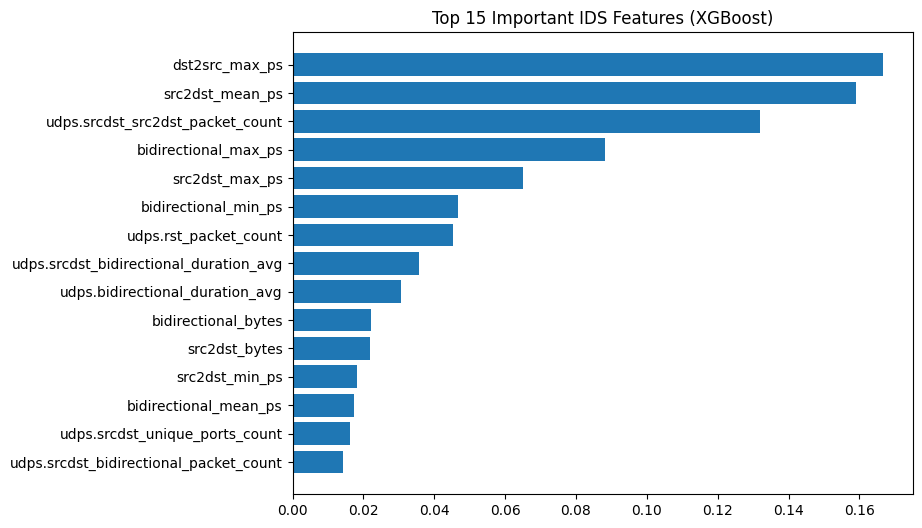

In [12]:
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 15 Important IDS Features (XGBoost)")
plt.show()